# Assignment 1: Neural Networks

Implement your code and answer all the questions. Once you complete the assignment and answer the questions inline, you can download the report in pdf (File->Download as->PDF) and send it to us, together with the code. 

**Don't submit additional cells in the notebook, we will not check them. Don't change parameters of the learning inside the cells.**

Assignment 1 consists of 4 sections:
* **Section 1**: Data Preparation
* **Section 2**: Multinomial Logistic Regression
* **Section 3**: Backpropagation
* **Section 4**: Neural Networks


In [1]:
# Import necessary standard python packages 
import numpy as np
import matplotlib.pyplot as plt

# Setting configuration for matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20


In [2]:
# Import python modules for this assignment

from uva_code.cifar10_utils import get_cifar10_raw_data, preprocess_cifar10_data
from uva_code.solver import Solver
from uva_code.losses import SoftMaxLoss, CrossEntropyLoss, HingeLoss
from uva_code.layers import LinearLayer, ReLULayer, SigmoidLayer, TanhLayer, SoftMaxLayer, ELULayer
from uva_code.models import Network
from uva_code.optimizers import SGD

%load_ext autoreload
%autoreload 2

## Section 1:  Data Preparation

In this section you will download [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html "CIFAR10") data which you will use in this assignment. 

**Make sure that everything has been downloaded correctly and all images are visible.**

In [3]:
# Get raw CIFAR10 data. For Unix users the script to download CIFAR10 dataset (get_cifar10.sh).
# Try to run script to download the data. It should download tar archive, untar it and then remove it. 
# If it is doesn't work for some reasons (like Permission denied) then manually download the data from 
# http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract it to cifar-10-batches-py folder inside 
# cifar10 folder.

X_train_raw, Y_train_raw, X_test_raw, Y_test_raw = get_cifar10_raw_data()

#Checking shapes, should be (50000, 32, 32, 3), (50000, ), (10000, 32, 32, 3), (10000, )
print("Train data shape: {0}").format(str(X_train_raw.shape))
print("Train labels shape: {0}").format(str(Y_train_raw.shape))
print("Test data shape: {0}").format(str(X_test_raw.shape))
print("Test labels shape: {0}").format(str(Y_test_raw.shape))

Train data shape: (50000, 32, 32, 3)
Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


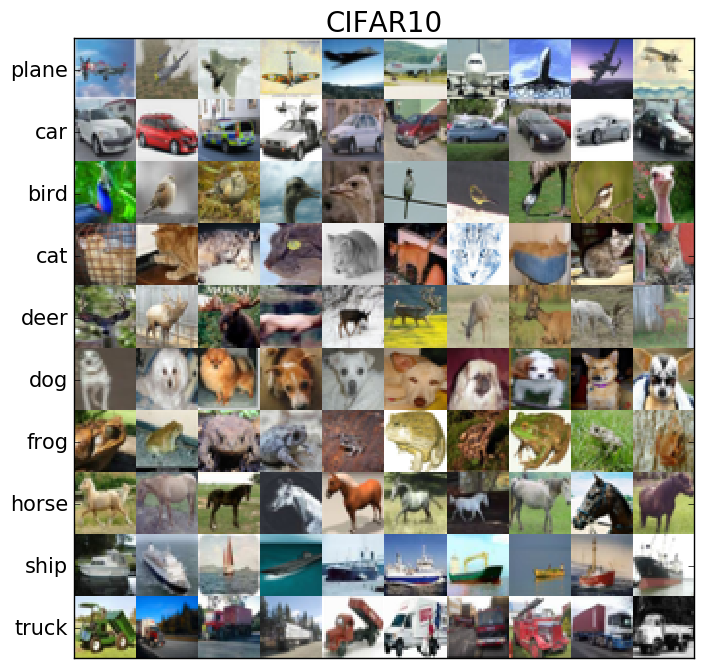

In [4]:
# Visualize CIFAR10 data
samples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(classes)
can = np.zeros((320, 320, 3),dtype='uint8')
for i, cls in enumerate(classes):
    idxs = np.flatnonzero(Y_train_raw == i) 
    idxs = np.random.choice(idxs, samples_per_class, replace = False)
    for j in range(samples_per_class):
        can[32 * i:32 * (i + 1), 32 * j:32 * (j + 1),:] = X_train_raw[idxs[j]]
plt.xticks([], [])
plt.yticks(range(16, 320, 32), classes)
plt.title('CIFAR10', fontsize = 20)
plt.imshow(can)
plt.show()

In [5]:
# Normalize CIFAR10 data by subtracting the mean image. With these data you will work in the rest of assignment.
# The validation subset will be used for tuning the hyperparameters.
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess_cifar10_data(X_train_raw, Y_train_raw, 
                                                                         X_test_raw, Y_test_raw, num_val = 1000)

#Checking shapes, should be (49000, 3072), (49000, ), (1000, 3072), (1000, ), (10000, 3072), (10000, ) 
print "Train data shape: {0}".format(str(X_train.shape))
print "Train labels shape: {0}".format(str(Y_train.shape))
print "Val data shape: {0}".format(str(X_val.shape))
print "Val labels shape: {0}".format(str(Y_val.shape))
print "Test data shape: {0}".format(str(X_test.shape))
print "Test labels shape: {0}".format(str(Y_test.shape))

Train data shape: (49000, 3072)
Train labels shape: (49000,)
Val data shape: (1000, 3072)
Val labels shape: (1000,)
Test data shape: (10000, 3072)
Test labels shape: (10000,)


### Data Preparation: Question 1 [4 points]

Neural networks and deep learning methods prefer the input variables to contain as raw data as possible. 
But in the vast majority of cases data need to be preprocessed. Suppose, you have two types of non-linear  activation functions ([Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and two types of normalization ([Per-example mean substraction](http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing#Per-example_mean_subtraction), [Standardization](http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing#Feature_Standardization)). What type of preprocessing you would prefer to use for each activation function and why? For example, in the previous cell we used per-example mean substraction.

**Your Answer**: I would choose Standardization for the Sigmoid activation function given that the derivative of sigmoid function for large values is zero and thus we will have slow learning. Moreover, I would prefer Per-example mean substraction for the ReLU, since keeping large values very far from zero, where the derivative of ReLU becomes equal to unit would result in very slow learning.

## Section 2: Multinomial Logistic Regression [5 points]

In this section you will get started by implementing a linear classification model called [Multinomial Logistic Regression](http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression). Later on you will extend this model to a neural network. You will train it by using the [mini-batch Stochastic Gradient Descent algorithm](http://sebastianruder.com/optimizing-gradient-descent/index.html#minibatchgradientdescent). You should implement how to sample batches, how to compute the loss, how to compute the gradient of the loss with respect to the parameters of the model and how to update the parameters of the model. 

You should get around 0.35 accuracy on the validation and test sets with the provided parameters.


In [6]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 1e-7
weight_decay = 3e+4
weight_scale = 0.0001

########################################################################################
# TODO:                                                                                #
# Initialize the weights W using a normal distribution with mean = 0 and std =         #
# weight_scale. Initialize the biases b with 0.                                        #
########################################################################################   
W = np.random.normal(loc=0.0, scale=weight_scale, size=(X_train.shape[1], num_classes))
b = np.ones(num_classes)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################

train_loss_history = []
train_acc_history = []

val_loss_history = []
val_acc_history = []

for iteration in range(num_iterations):
    ########################################################################################
    # TODO:                                                                                #
    # Sample a random mini-batch with the size of batch_size from the train set. Put the   #
    # images to X_train_batch and labels to Y_train_batch variables.                       #
    ########################################################################################
    samples = np.random.choice(X_train.shape[0], size=batch_size, replace=False)
    X_train_batch = X_train[samples]
    Y_train_batch = Y_train[samples]
    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    ########################################################################################
    # TODO:                                                                                #
    # Compute the loss and the accuracy of the multinomial logistic regression classifier  #
    # on X_train_batch, Y_train_batch. The loss should be an average of the losses on all  #
    # samples in the mini-batch. Include to the loss L2-regularization over the weight     #
    # matrix W with regularization parameter equals to weight_decay.                       #            
    ########################################################################################
    exp = np.exp(np.dot(X_train_batch, W) + b)
    exp_nor = exp.T / np.sum(exp, axis = 1) # add bias somewhere
    a = np.zeros((batch_size, num_classes))
    for idx, label in enumerate(Y_train_batch): a[idx, label] = 1.0
    train_loss = - (np.log(np.sum(exp_nor * a.T)) / batch_size) + (.5*weight_decay) * np.sum(W**2)
    train_acc = float(sum(np.argmax(exp_nor, axis=0) == Y_train_batch)) / batch_size
    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    ########################################################################################
    # TODO:                                                                                #
    # Compute the gradients of the loss with the respect to the weights and biases. Put    #
    # them in dW and db variables.                                                         #
    ########################################################################################
    dW = - (np.dot(X_train_batch.T, (a - exp_nor.T)) / batch_size) + (weight_decay * W)
    db = - (np.sum(a - exp_nor.T, axis=0) / batch_size)
    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    ########################################################################################
    # TODO:                                                                                #
    # Update the weights W and biases b using the Stochastic Gradient Descent update rule. #
    ########################################################################################
    W = W - (learning_rate * dW)
    b = b - (learning_rate * db)
    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    
    if iteration % val_iteration == 0 or iteration == num_iterations - 1:
        ########################################################################################
        # TODO:                                                                                #
        # Compute the loss and the accuracy on the validation set.                             #
        ########################################################################################
        exp = np.exp(np.dot(X_val, W) + b)
        exp_nor = exp.T / np.sum(exp, axis = 1) # add bias somewhere
        a = np.zeros((X_val.shape[0], num_classes))
        for idx, label in enumerate(Y_val): a[idx, label] = 1.0
        val_loss = - (np.log(np.sum(exp_nor * a.T)) / X_val.shape[0]) + (.5*weight_decay) * np.sum(W**2)
        val_acc = float(sum(np.argmax(exp_nor, axis=0) == Y_val)) / X_val.shape[0]
        ########################################################################################
        #                              END OF YOUR CODE                                        #
        ########################################################################################
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        # Output loss and accuracy during training
        print("Iteration {0:d}/{1:d}. Train Loss = {2:.3f}, Train Accuracy = {3:.3f}".
              format(iteration, num_iterations, train_loss, train_acc))
        print("Iteration {0:d}/{1:d}. Validation Loss = {2:.3f}, Validation Accuracy = {3:.3f}".
              format(iteration, num_iterations, val_loss, val_acc))

########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################
exp = np.exp(np.dot(X_test, W) + b)
exp_nor = exp.T / np.sum(exp, axis = 1) # add bias somewhere
a = np.zeros((X_test.shape[0], num_classes))
for idx, label in enumerate(Y_test): a[idx, label] = 1.0
test_acc = float(sum(np.argmax(exp_nor, axis=0) == Y_test)) / X_test.shape[0]
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))

Iteration 0/1500. Train Loss = 4.587, Train Accuracy = 0.125
Iteration 0/1500. Validation Loss = 4.570, Validation Accuracy = 0.125
Iteration 100/1500. Train Loss = 2.526, Train Accuracy = 0.275
Iteration 100/1500. Validation Loss = 2.523, Validation Accuracy = 0.285
Iteration 200/1500. Train Loss = 1.408, Train Accuracy = 0.285
Iteration 200/1500. Validation Loss = 1.412, Validation Accuracy = 0.328
Iteration 300/1500. Train Loss = 0.799, Train Accuracy = 0.340
Iteration 300/1500. Validation Loss = 0.807, Validation Accuracy = 0.345
Iteration 400/1500. Train Loss = 0.468, Train Accuracy = 0.310
Iteration 400/1500. Validation Loss = 0.477, Validation Accuracy = 0.346
Iteration 500/1500. Train Loss = 0.287, Train Accuracy = 0.350
Iteration 500/1500. Validation Loss = 0.298, Validation Accuracy = 0.358
Iteration 600/1500. Train Loss = 0.189, Train Accuracy = 0.325
Iteration 600/1500. Validation Loss = 0.201, Validation Accuracy = 0.350
Iteration 700/1500. Train Loss = 0.137, Train Accura

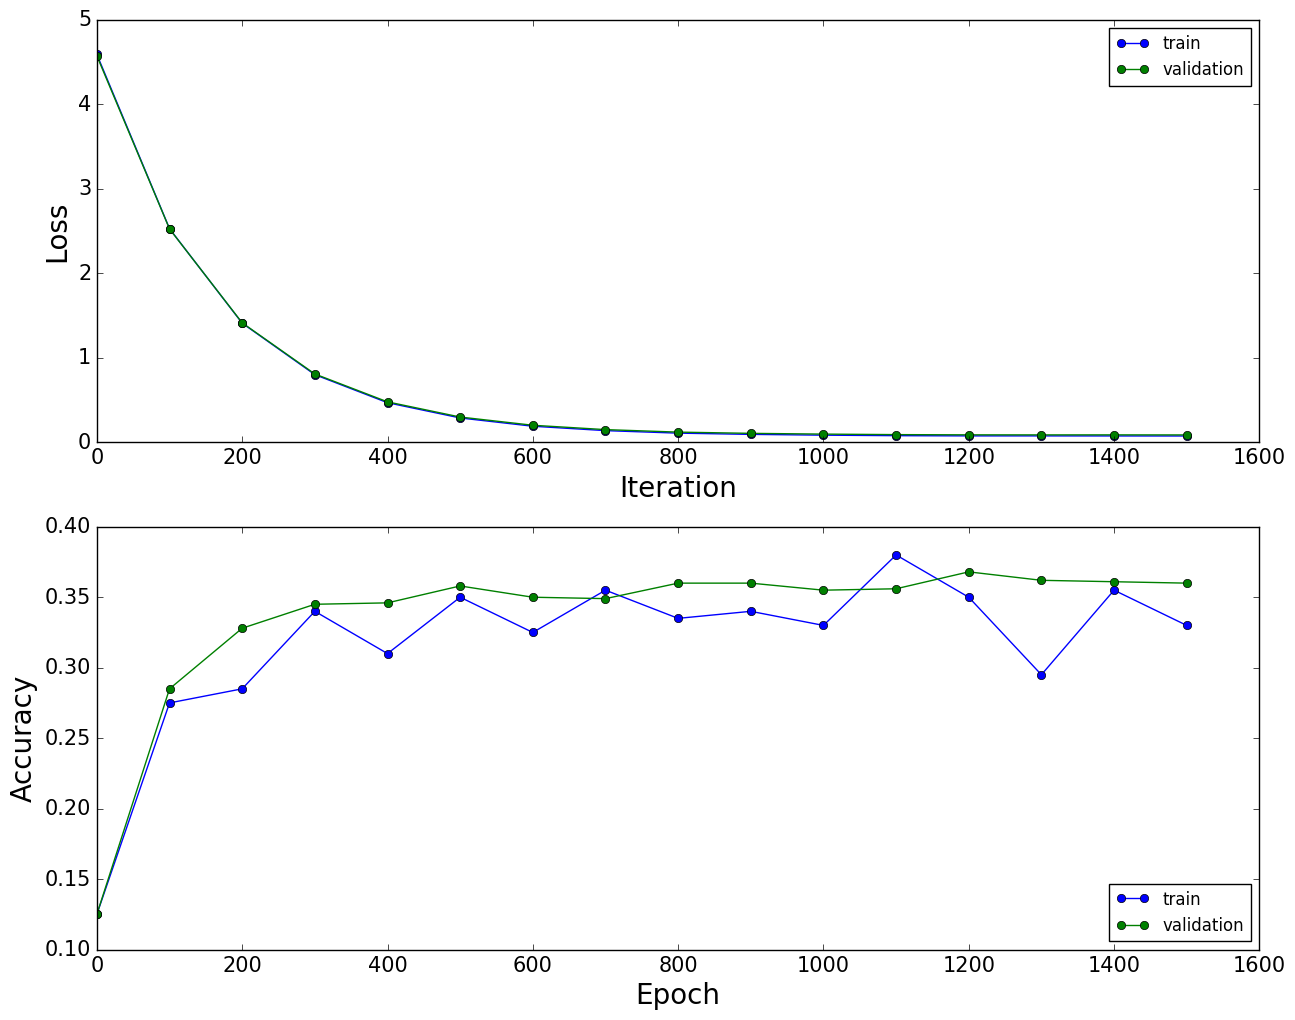

In [7]:
# Visualize a learning curve of multinomial logistic regression classifier
plt.subplot(2, 1, 1)
plt.plot(range(0, num_iterations + 1, val_iteration), train_loss_history, '-o', label = 'train')
plt.plot(range(0, num_iterations + 1, val_iteration), val_loss_history, '-o', label = 'validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(range(0, num_iterations + 1, val_iteration), train_acc_history, '-o', label='train')
plt.plot(range(0, num_iterations + 1, val_iteration), val_acc_history, '-o', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

### Multinomial Logistic Regression: Question 1 [4 points]

What is the value of the loss and the accuracy you expect to obtain at iteration = 0 and why? Consider weight_decay = 0.

**Your Answer**: At iteration zero we expect very large loss and very low accuracy. Given that we use L_2 normalization the weight clearly depend on the initialization which tends to give large values. Moreover, the loss without considering the added value from L_2 normalization is low negative value since there is no accuracy given the initialized weights. Accuracy is low and that is because the classification is fully depended on the randomly initialized weights.

### Multinomial Logistic Regression: Question 2 [4 points]

Name at least three factors that determine the size of batches in practice and briefly motivate your answers. The factors might be related to computational or performance aspects.

**Your Answer**: 1) Memory requirements, increasing the batch size increases the memory allocated for the large arrays. 2) Speed up, keeping the batch size small increases the speed of learning since we get more updates in the same time duration. 3) Accuracy, the larger the batch size the better the accuracy of the parameter updates, minimum batch size increases the speed but we should also keep it large enough to cancel noise.

### Mulinomial Logistic Regression: Question 3 [4 points]

Does the learning rate depend on the batch size? Explain how you should change the learning rate with respect to changes of the batch size.

Name two extreme choices of a batch size and explain their advantages and disadvantages.

**Your Answer**: Large batch size means accuracy in the derivatives which means that we can take big steps and therefore use a high learning rate. Minimal batch sizes tend to give noisy gradients of the loss functions and therefore smaller steps are required in order to avoid huge steps in the wrong direction. In general larger batch sizes need larger learning rate to result in faster learning.

### Multinomial Logistic Regression: Question 4 [4 points]

Suppose that the weight matrix W has the shape (num_features, num_classes). How can you describe the columns of the weight matrix W? What are they representing? Why? 

**Your Answer**: The columns of the matrix W give the weights of each feature for the different classes. The represent how important is each feature to determine each class.

**Hint**: Before answering the question visualize the columns of the weight matrix W in the cell below.

plane


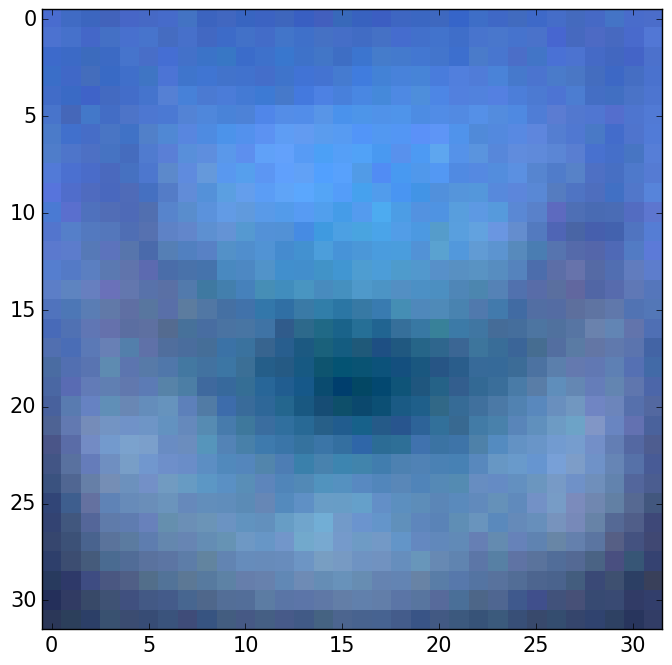

car


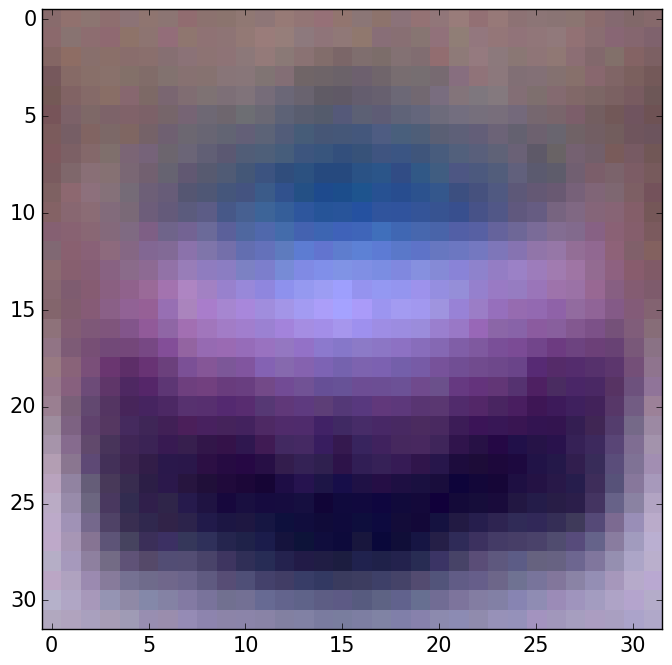

bird


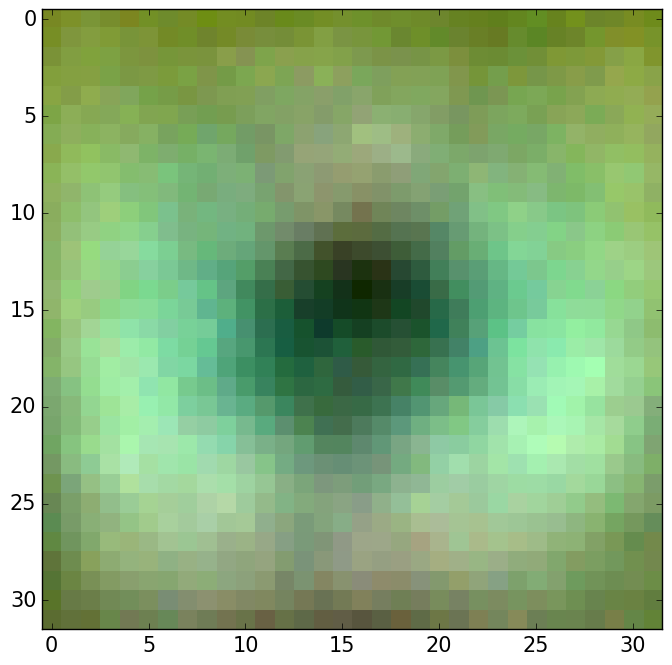

cat


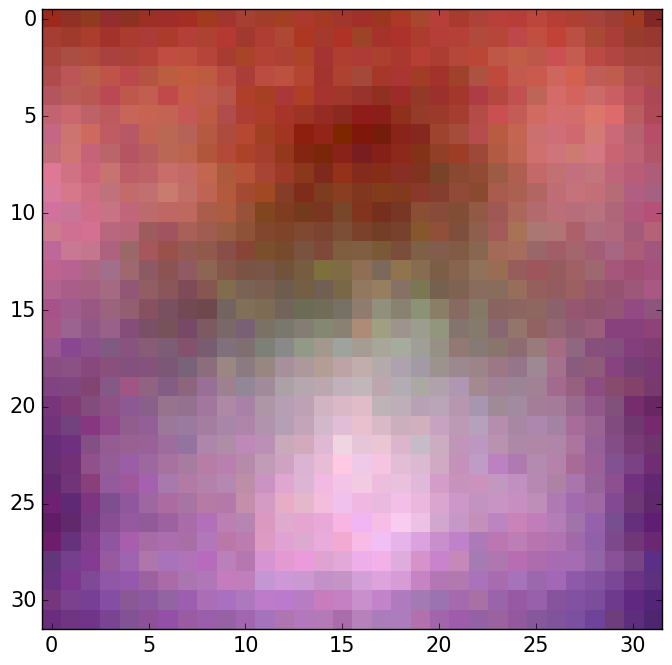

deer


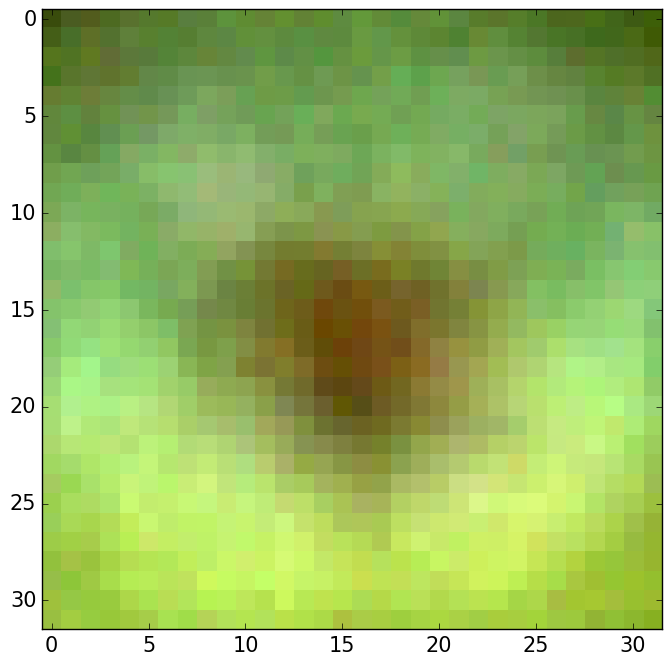

dog


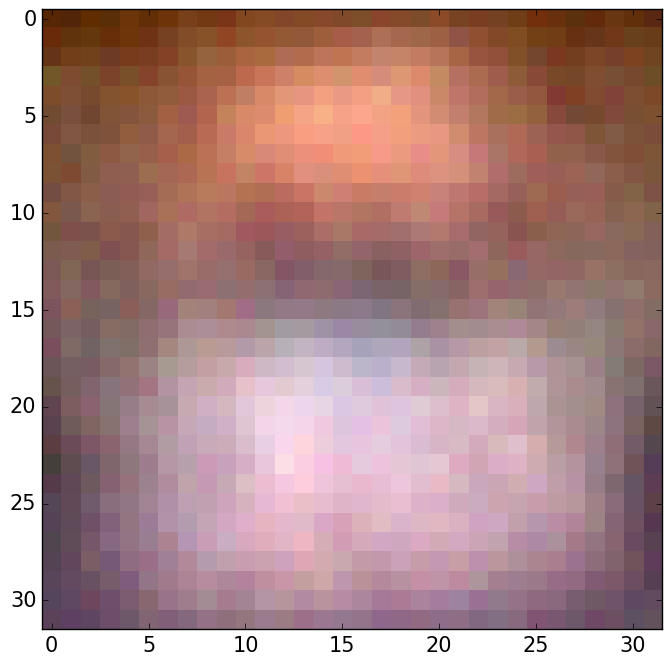

frog


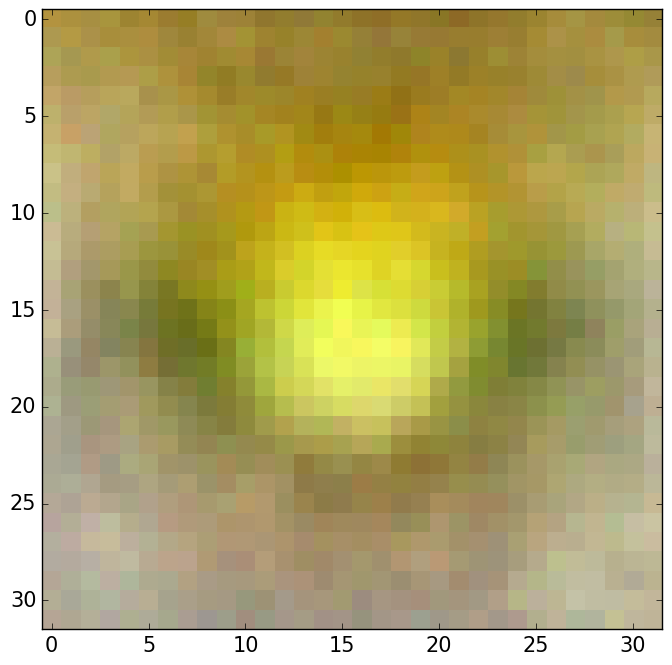

horse


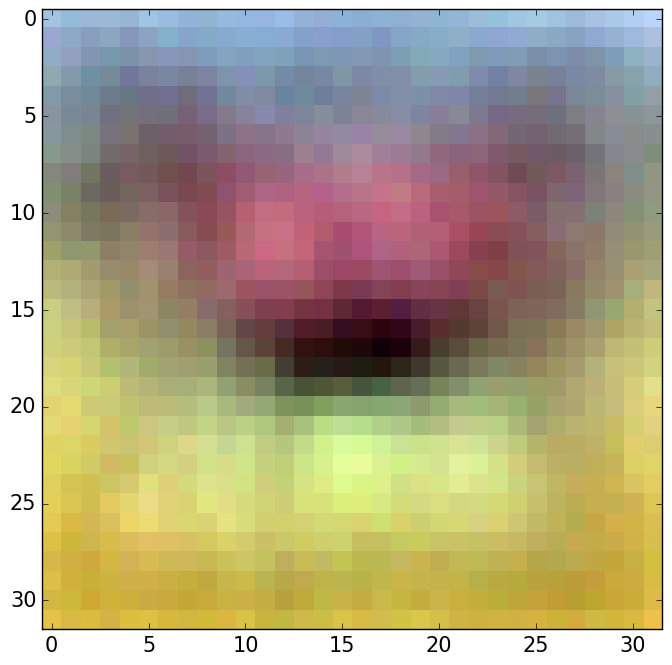

ship


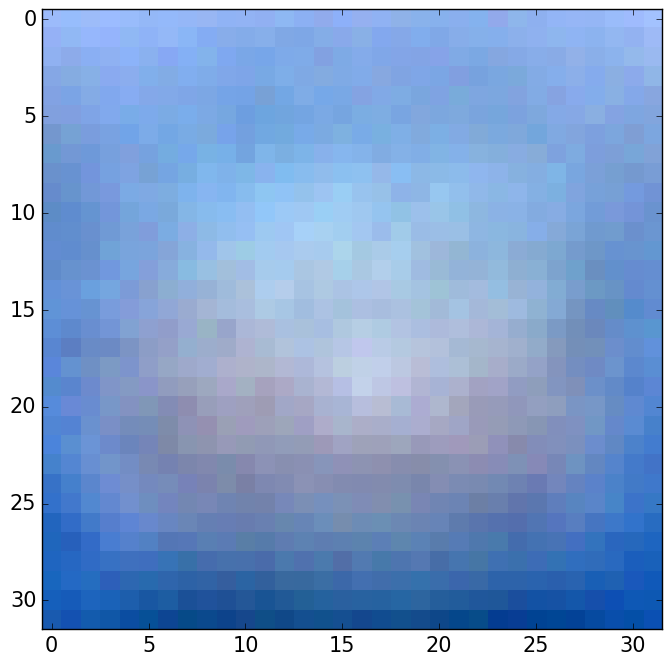

truck


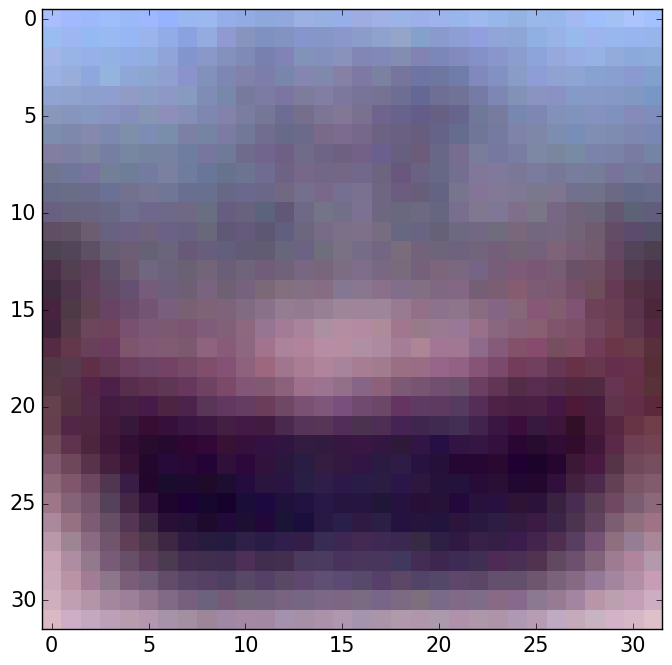

In [8]:
########################################################################################
# TODO:                                                                                #
# Visualize the learned weights for each class.                                        #
########################################################################################
for i in range(num_classes):
    print classes[i]
    W_nor = (W[:,i].reshape((32,32,3)) - np.min(W[:,i]))
    W_nor_256 = np.array((255.0 * W_nor / np.max(W_nor)), dtype='uint8')
    plt.imshow(W_nor_256)
    plt.show()
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################

## Section 3: Backpropagation

Follow the instructions and solve the tasks in paper_assignment_1.pdf. Write your solutions in a separate pdf file. You don't need to put anything here.
    

## Section 4: Neural Networks [10 points]

A modular implementation of neural networks allows to define deeper and more flexible architectures. In this section you will implement the multinomial logistic regression classifier from the Section 2 as a one-layer neural network that consists of two parts: a linear transformation layer (module 1) and a softmax loss layer (module 2).

You will implement the multinomial logistic regression classifier as a modular network by following next steps:

1. Implement the forward and backward passes for the linear layer in **layers.py** file. Write your code inside the ***forward*** and ***backward*** methods of ***LinearLayer*** class. Compute the regularization loss of the weights inside the ***layer_loss*** method of ***LinearLayer*** class. 
2. Implement the softmax loss computation in **losses.py** file. Write your code inside the ***SoftMaxLoss*** function. 
3. Implement the ***forward***, ***backward*** and ***loss*** methods for the ***Network*** class inside the **models.py** file.
4. Implement the SGD update rule inside ***SGD*** class in **optimizers.py** file.
5. Implement the ***train_on_batch***, ***test_on_batch***, ***fit***, ***predcit***, ***score***, ***accuracy*** methods of ***Solver*** class in ***solver.py*** file.

**All computations should be implemented in vectorized. Don't loop over samples in the mini-batch.**

You should get the same results for the next cell as in Section 2. **Don't change the parameters**.


In [9]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 1e-7
weight_decay = 3e+4
weight_scale = 0.0001

########################################################################################
# TODO:                                                                                #
# Build the multinomial logistic regression classifier using the Network model. You    #
# will need to use add_layer and add_loss methods. Train this model using Solver class #
# with SGD optimizer. In configuration of the optimizer you need to specify only       #
# learning rate. Use the fit method to train classifier. Don't forget to include       #
# X_val and Y_val in arguments to output the validation loss and accuracy during       #
# training. Set the verbose to True to compare with the  multinomial logistic          #
# regression classifier from the Section 2.                                            #
########################################################################################
model = Network()
model.add_layer(LinearLayer(layer_params = {'input_size': X_train.shape[1], 'output_size':num_classes, 'weight_decay': weight_decay, 'weight_scale':weight_scale}))
model.add_loss(SoftMaxLoss)
optimizer = SGD()
optimizer_config = {'learning_rate': learning_rate}
solver = Solver(model)
solver.fit(X_train, Y_train, optimizer, optimizer_config,
           x_val=X_val, y_val=Y_val, batch_size=batch_size,
           num_iterations=num_iterations,
           val_iteration=val_iteration,
           verbose=True)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################

########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################
test_acc = solver.score(solver.predict(X_test), Y_test)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))

Iteration 0/1500: Train Loss = 6.907, Train Accuracy = 0.125
Iteration 0/1500. Validation Loss = 2.311, Validation Accuracy = 0.125
Iteration 100/1500: Train Loss = 6.656, Train Accuracy = 0.255
Iteration 100/1500. Validation Loss = 2.060, Validation Accuracy = 0.279
Iteration 200/1500: Train Loss = 6.674, Train Accuracy = 0.310
Iteration 200/1500. Validation Loss = 1.990, Validation Accuracy = 0.319
Iteration 300/1500: Train Loss = 6.659, Train Accuracy = 0.325
Iteration 300/1500. Validation Loss = 1.951, Validation Accuracy = 0.335
Iteration 400/1500: Train Loss = 6.607, Train Accuracy = 0.315
Iteration 400/1500. Validation Loss = 1.924, Validation Accuracy = 0.348
Iteration 500/1500: Train Loss = 6.709, Train Accuracy = 0.370
Iteration 500/1500. Validation Loss = 1.905, Validation Accuracy = 0.357
Iteration 600/1500: Train Loss = 6.640, Train Accuracy = 0.335
Iteration 600/1500. Validation Loss = 1.889, Validation Accuracy = 0.364
Iteration 700/1500: Train Loss = 6.664, Train Accura

### Neural Networks: Task 1 [5 points]

Tuning hyperparameters is very important even for multinomial logistic regression. 

What are the best learning rate and weight decay which produces the highest accuracy on the validation set? What is test accuracy of the model trained with the found best hyperparameters values?

**Your Answer**: Learning rate = 3.334000e-05, weight decay = 1.501500e+04: Validation Accuracy = 0.343 :(

***Hint:*** You should be able to get the test accuracy more than 0.4.

Implement the tuning of hyperparameters (learning rate and weight decay) in the next cell. 

In [10]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
weight_scale = 0.0001

# You should try diffierent range of hyperparameters. 
learning_rates = np.linspace(1e-4, 1e-8, 10)
weight_decays = np.linspace(3e+01, 3e+04, 5)

best_val_acc = -1
best_solver = None
for learning_rate in learning_rates:
    for weight_decay in weight_decays:
        ########################################################################################
        # TODO:                                                                                #
        # Implement the tuning of hyperparameters for the multinomial logistic regression. Save#
        # maximum of the validation accuracy in best_val_acc and corresponding solver to       #
        # best_solver variables. Store the maximum of the validation score for the current     #
        # setting of the hyperparameters in cur_val_acc variable.                              #
        ########################################################################################
        model = Network()
        model.add_layer(LinearLayer(layer_params = {'input_size': X_train.shape[1],
                                                    'output_size':num_classes,
                                                    'weight_decay': weight_decay,
                                                    'weight_scale':weight_scale}))
        model.add_loss(SoftMaxLoss)
        optimizer = SGD()
        optimizer_config = {'learning_rate': learning_rate}
        solver = Solver(model)
        solver.fit(X_train, Y_train, optimizer, optimizer_config,
           x_val=X_val, y_val=Y_val, batch_size=batch_size,
           num_iterations=num_iterations,
           val_iteration=val_iteration,
           verbose=False)
        cur_val_acc = solver.score(solver.predict(X_val), Y_val)
        if cur_val_acc > best_val_acc:
            best_solver = solver
            best_val_acc = cur_val_acc
        ########################################################################################
        #                              END OF YOUR CODE                                        #
        ########################################################################################
        print("Learning rate = {0:e}, weight decay = {1:e}: Validation Accuracy = {2:.3f}".format(
            learning_rate, weight_decay, cur_val_acc))    

########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set for the best solver.                          #
########################################################################################
test_acc = best_solver.score(best_solver.predict(X_test), Y_test)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Best Test Accuracy = {0:.3f}".format(test_acc))

Learning rate = 1.000000e-04, weight decay = 3.000000e+01: Validation Accuracy = 0.273
Learning rate = 1.000000e-04, weight decay = 7.522500e+03: Validation Accuracy = 0.296
Learning rate = 1.000000e-04, weight decay = 1.501500e+04: Validation Accuracy = 0.282
Learning rate = 1.000000e-04, weight decay = 2.250750e+04: Validation Accuracy = 0.291
Learning rate = 1.000000e-04, weight decay = 3.000000e+04: Validation Accuracy = 0.298
Learning rate = 8.889000e-05, weight decay = 3.000000e+01: Validation Accuracy = 0.273
Learning rate = 8.889000e-05, weight decay = 7.522500e+03: Validation Accuracy = 0.303
Learning rate = 8.889000e-05, weight decay = 1.501500e+04: Validation Accuracy = 0.263
Learning rate = 8.889000e-05, weight decay = 2.250750e+04: Validation Accuracy = 0.342
Learning rate = 8.889000e-05, weight decay = 3.000000e+04: Validation Accuracy = 0.268
Learning rate = 7.778000e-05, weight decay = 3.000000e+01: Validation Accuracy = 0.296
Learning rate = 7.778000e-05, weight decay 

### Neural Networks: Task 2 [5 points]

Implement a two-layer neural network with a ReLU activation function. Write your code for the ***forward*** and ***backward*** methods of ***ReLULayer*** class in **layers.py** file.

Train the network with the following structure: linear_layer-relu-linear_layer-softmax_loss. You should get the accuracy on the test set around 0.44. 

In [11]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Number of hidden units in a hidden layer.
num_hidden_units = 100

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 2e-3
weight_decay = 0
weight_scale = 0.0001

########################################################################################
# TODO:                                                                                #
# Build the model with the structure: linear_layer-relu-linear_layer-softmax_loss.     #
# Train this model using Solver class with SGD optimizer. In configuration of the      #
# optimizer you need to specify only the learning rate. Use the fit method to train.   # 
########################################################################################
model = Network()
model.add_layer(LinearLayer(layer_params = {'input_size': X_train.shape[1], 'output_size':num_classes, 'weight_decay': weight_decay, 'weight_scale':weight_scale}))
model.add_loss(SoftMaxLoss)
optimizer = SGD()
optimizer_config = {'learning_rate': learning_rate}
solver = Solver(model)
solver.fit(X_train, Y_train, optimizer, optimizer_config,
           x_val=X_val, y_val=Y_val, batch_size=batch_size,
           num_iterations=num_iterations,
           val_iteration=val_iteration,
           verbose=True)
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
    
########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################
test_acc = None
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))

Iteration 0/1500: Train Loss = 2.305, Train Accuracy = 0.125
Iteration 0/1500. Validation Loss = nan, Validation Accuracy = 0.208


uva_code/losses.py:78: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
uva_code/losses.py:79: RuntimeWarning: invalid value encountered in divide
  exp_nor = exp / np.sum(exp, axis=1, keepdims=True)
uva_code/losses.py:80: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(exp_nor[range(y.shape[0]), y])) / y.shape[0]


Iteration 100/1500: Train Loss = nan, Train Accuracy = 0.095
Iteration 100/1500. Validation Loss = nan, Validation Accuracy = 0.087
Iteration 200/1500: Train Loss = nan, Train Accuracy = 0.095
Iteration 200/1500. Validation Loss = nan, Validation Accuracy = 0.087
Iteration 300/1500: Train Loss = nan, Train Accuracy = 0.070
Iteration 300/1500. Validation Loss = nan, Validation Accuracy = 0.087
Iteration 400/1500: Train Loss = nan, Train Accuracy = 0.095
Iteration 400/1500. Validation Loss = nan, Validation Accuracy = 0.087
Iteration 500/1500: Train Loss = nan, Train Accuracy = 0.125
Iteration 500/1500. Validation Loss = nan, Validation Accuracy = 0.087
Iteration 600/1500: Train Loss = nan, Train Accuracy = 0.110
Iteration 600/1500. Validation Loss = nan, Validation Accuracy = 0.087
Iteration 700/1500: Train Loss = nan, Train Accuracy = 0.110
Iteration 700/1500. Validation Loss = nan, Validation Accuracy = 0.087
Iteration 800/1500: Train Loss = nan, Train Accuracy = 0.120
Iteration 800/1

ValueError: Unknown format code 'f' for object of type 'str'

### Neural Networks: Task 3 [5 points]

Why the ReLU layer is important? What will happen if we exclude this layer? What will be the accuracy on the test set?

**Your Answer**: Put your answer here.
    
Implement other activation functions: [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [Tanh](https://en.wikipedia.org/wiki/Hyperbolic_function#Hyperbolic_tangent) and [ELU](https://arxiv.org/pdf/1511.07289v3.pdf) functions. 
Write your code for the ***forward*** and ***backward*** methods of ***SigmoidLayer***, ***TanhLayer*** and ***ELULayer*** classes in **layers.py** file.


In [ ]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Number of hidden units in a hidden layer. 
num_hidden_units = 100

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 2e-3
weight_decay = 0
weight_scale = 0.0001

# Store results here
results = {}
layers_name = ['ReLU', 'Sigmoid', 'Tanh', 'ELU']
layers = [ReLULayer(), SigmoidLayer(), TanhLayer(), ELULayer()]

for layer_name, layer in zip(layers_name, layers):
    ########################################################################################
    # Build the model with the structure: linear_layer-activation-linear_layer-softmax_loss# 
    # Train this model using Solver class with SGD optimizer. In configuration of the      #
    # optimizer you need  to specify only the learning rate. Use the fit method to train.  #
    # Store validation history in results dictionary variable.                             # 
    ########################################################################################

    ########################################################################################
    #                              END OF YOUR CODE                                        #
    ########################################################################################
    results[layer_name] = val_acc_history


In [ ]:
# Visualize a learning curve for different activation functions
for layer_name in layers_name:
    plt.plot(range(0, num_iterations + 1, val_iteration), results[layer_name], '-o', label = layer_name)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Neural Networks: Task 4 [10 points]

Although typically a [Softmax](https://en.wikipedia.org/wiki/Softmax_function) layer is coupled with a [Cross Entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression), this is not necessary and you can use a different loss function. Next, implement the network with the Softmax layer paired with a [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss). Beware, with the Softmax layer all the output dimensions depend on all the input dimensions, hence, you need to compute the Jacobian of derivatives $\frac{\partial o_i}{dx_j}$. 

Implement the ***forward*** and ***backward*** methods for 
***SoftMaxLayer*** in **layers.py** file and ***CrossEntropyLoss*** and ***HingeLoss*** in **losses.py** file. You should implement multi-class cross-entropy and hinge losses. 

Results of using SoftMaxLoss and SoftMaxLayer + CrossEntropyLoss should be the same.


In [ ]:
# DONT CHANGE THE SEED AND THE DEFAULT PARAMETERS. OTHERWISE WE WILL NOT BE ABLE TO CORRECT YOUR ASSIGNMENT!
# Seed
np.random.seed(42)

# Default parameters. 
num_iterations = 1500
val_iteration = 100
batch_size = 200
learning_rate = 2e-3
weight_decay = 0
weight_scale = 0.0001

########################################################################################
# TODO:                                                                                #
# Build the model with the structure:                                                  #
# linear_layer-relu-linear_layer-softmax_layer-hinge_loss.                             #
# Train this model using Solver class with SGD optimizer. In configuration of the      #
# optimizer you need to specify only the learning rate. Use the fit method to train.   # 
########################################################################################
model = None
optimizer = None
optimizer_config = None
solver = None
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################

########################################################################################
# TODO:                                                                                #
# Compute the accuracy on the test set.                                                #
########################################################################################
test_acc = None
########################################################################################
#                              END OF YOUR CODE                                        #
########################################################################################
print("Test Accuracy = {0:.3f}".format(test_acc))